## 3. Download Data
    채점과 협력 코딩의 용이성을 위해서 파일을 다운받을 수 있도록 했습니다.
    로컬에 자동으로 다운받아집니다.

In [24]:
#그냥 실행시키시면 자동으로 다운로드 됩니다.
import os
import tqdm
files = {"X_val":"1-7CBfLwKpPAqFqA1vq8EZJe1olGw3zsu",
         "X_train":"1-18adV66ZrHnpzsfer6MfS7HU71CT0Cf",
         "X_test":"1-9vV59f_kCgTuh-P-_Nq5uSHzshBCpvT",
         "y_train":"1LH2LoFZg8YgjBHCNvPEGD_ltROLohaYI",
         "y_test":"1-4nHZFlaHKshaa_CE6w36z4gL9bVrz6k",
         "y_val":"1-1N-5ilxadcYtWguUPAS21BbfzUiLgDl"}
print("Now starting To download!")
for name, idx in tqdm.tqdm_notebook(files.items()):
    os.system(f'wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id={idx}" -O- | sed -rn "s/.*confirm=([0-9A-Za-z_]+).*/\1\n/p")&id={idx}" -O {name}.npy && rm -rf /tmp/cookies.txt')

Now starting To download!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [25]:
import numpy as np
X_val = np.load("/content/X_val.npy")
X_test = np.load("/content/X_test.npy")
X_train = np.load("/content/X_train.npy")

y_val = np.load("/content/y_val.npy")
y_test = np.load("/content/y_test.npy")
y_train = np.load("/content/y_train.npy")

## AutoEncoder
    차원축소를 위한 네트워크입니다.

In [26]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [32]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, ReLU
from keras.models import Sequential, Model

# class로 AutoEncoder를 구성했습니다.
# 깔끔하게 컨벤션 지키는걸 좋아해서 최대한 깔끔하게 짜보았습니다.
class AutoEncoder():
    def __init__(self, img_shape):
        self.img_shape = img_shape
        self.inp = Input(img_shape)

    def __encoder__(self):
        encoder = Sequential()
        encoder.add(InputLayer(self.img_shape))
        encoder.add(Flatten())
        encoder.add(Dense(1024))
        encoder.add(ReLU())
        encoder.add(Dense(512))
        encoder.add(ReLU())
        encoder.add(Dense(256))
        return encoder

    def __decoder__(self, inp_size):
        decoder = Sequential()
        decoder.add(InputLayer((256,)))
        decoder.add(Dense(512))
        decoder.add(ReLU())
        decoder.add(Dense(1024))
        decoder.add(Dense(np.prod(self.img_shape))) # np.prod(self.img_shape) is the same as 32*32*3, it's more generic than saying 3072
        decoder.add(Reshape(self.img_shape))
        return decoder

    def fit(self, X_train, epochs = 10000, best_save_name = None):
        code = self.__encoder__()(self.inp)
        de_size = code[-1].shape
        reconstruction = self.__decoder__(de_size)(code)
        self.autoencoder = Model(self.inp, reconstruction)
        self.autoencoder.compile(optimizer='adagrad', loss='mse') 
        if best_save_name != None:
            cp = tf.keras.callbacks.ModelCheckpoint(f"/content/{best_save_name}.h5",
                                            monitor="val_loss",
                                            save_best_only=True)
            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
            self.autoencoder.fit(X_train, X_train, shuffle = True, epochs=epochs, callbacks = [cp, es], validation_data= (X_val, X_val), batch_size = 16)
        else:
            self.autoencoder.fit(X_train, X_train, shuffle = True, epochs=epochs, validation_data= (X_val, X_val), batch_size = 16)

    def predict(self,X_val):
        encoder = self.autoencoder.layers[-2](self.inp)
        encoder = Model(self.inp, encoder)
        encoder.compile(optimizer='adagrad', loss='mse')
        return encoder.predict((X_val, X_val))

In [33]:
IMG_SHAPE = X_train.shape[1:]
AE1 = AutoEncoder(IMG_SHAPE)
AE1.fit(X_train, epochs=1000, best_save_name = "AE1_best")
#학습 중간에 종료하였습니다.

Epoch 1/1000
10/10 [==============================] - 10s 1s/step - loss: 61734.5117 - val_loss: 61764.5742
Epoch 2/1000
10/10 [==============================] - 10s 1000ms/step - loss: 65868.3906 - val_loss: 60846.6328
Epoch 3/1000
10/10 [==============================] - 14s 1s/step - loss: 64482.9609 - val_loss: 60340.6289
Epoch 4/1000
10/10 [==============================] - 15s 1s/step - loss: 53734.4102 - val_loss: 60155.3789
Epoch 5/1000
10/10 [==============================] - 16s 2s/step - loss: 53420.2422 - val_loss: 60144.6680
Epoch 6/1000
10/10 [==============================] - ETA: 0s - loss: 43591.7266

KeyboardInterrupt: ignored

In [37]:
X_train_ec = AE1.predict(X_train)
X_test_ec = AE1.predict(X_test)
X_val_ec = AE1.predict(X_val)

from sklearn.preprocessing import StandardScaler
sts = StandardScaler()
X_train_ec = sts.fit_transform(X_train_ec)
X_test_ec = sts.transform(X_test_ec)
X_val_ec = sts.transform(X_val_ec)

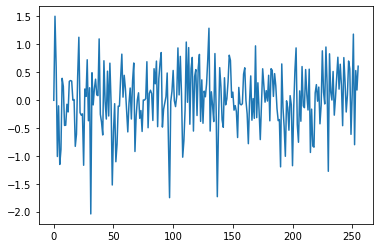

In [38]:
import matplotlib.pyplot as plt
plt.plot(X_train_ec[0])
#오토인코더를 통해 차원을 축소하였고, 해당 데이터를 표현했습니다. 256의 길이를 지니기 때문에, 그래프에도 256까지의 데이터가 표현됩니다.

In [39]:
np.save( '/content/drive/MyDrive/deep_learning/FINASL/final_code/X_train_enc',X_train_ec)
np.save( '/content/drive/MyDrive/deep_learning/FINASL/final_code/X_test_enc',X_test_ec)
np.save( '/content/drive/MyDrive/deep_learning/FINASL/final_code/X_val_enc',X_val_ec)